This is a notebook that analyses the data from XCMS run in positive mode.

In [1]:
import pandas, numpy, seaborn, qnorm

In [2]:
import scipy, scipy.signal, scipy.stats

In [3]:
import matplotlib, matplotlib.pyplot
matplotlib.rcParams.update({'font.size':20, 
                            'font.family':'sans-serif', 
                            'xtick.labelsize':16, 
                            'ytick.labelsize':16, 
                            'figure.figsize':(16, 9), 
                            'axes.labelsize':20
                           })

# user-defined variables

In [4]:
input_data_file = '/home/adrian/projects/vigur/data/lipidomics/072/xcms/pos/PMVECs_EC72_Lipids_POS_29032022_withIS.csv'
metadata_file = '/home/adrian/projects/vigur/data/lipidomics/072/xcms/pos/EC-072 SAMPLE LIST_BATCHES_FORLCMS_INTRA_Lipidomics_FINAL_23032022.xlsx'

# read information

## read data

In [5]:
df = pandas.read_csv(input_data_file)
df.shape

/tmp/ipykernel_443324/1072133223.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pandas.read_csv(input_data_file)


(22507, 223)

## read metadata

In [6]:
metadata = pandas.read_excel(metadata_file, sheet_name='Master Sample List POS', index_col='File')
metadata.head()

,LCMS_SAMPLE,MS file,LC file,Sample ID,Experiment,Timepoint,Treatment,Rep,M/R/C,Total cells per well,Cell Count,MS BATCH,MS BATCH.1,Polarity
File,,,,,,,,,,,,,,
EC72_Lipidomics_000094,Solvent,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B2_1,POS
EC72_Lipidomics_000095,Pool,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B2_1,POS
EC72_Lipidomics_000096,Solvent,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B2_1,POS
EC72_Lipidomics_000097,POS_072-153_5 µM epi:nor_24,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,072-153,2.0,24.0,5 µM epi:nor,1.0,C,3.33*10^5,333000.0,2.0,B2_1,POS
EC72_Lipidomics_000098,POS_072-156_TNFa_24,Aris_Neutrophiles_SCAN_pos,CSH_LIPID_Freyr-400flow,072-156,2.0,24.0,TNFa,1.0,C,3.40*10^5,340000.0,2.0,B2_1,POS


# manipulate information

In [7]:
# merge mz and RT as unique identifier
df.loc[:, 'unique_ID'] = df.loc[:, 'rt'].astype(str) + '_' + df.loc[:, 'mz'].astype(str)
df.set_index('unique_ID', inplace=True)
df.sort_index(inplace=True)

print(df.shape)
df.head()

(22507, 223)


,Unnamed: 0,mz,mzmin,mzmax,rt,rtmin,rtmax,rt(min),Internal Standard,LIPIDOMIX,...,EC72_Lipidomics_000210,EC72_Lipidomics_000211,EC72_Lipidomics_000212,EC72_Lipidomics_000213,EC72_Lipidomics_000214,EC72_Lipidomics_000215,EC72_Lipidomics_000216,isotopes,adduct,pcgroup
unique_ID,,,,,,,,,,,,,,,,,,,,,
100.182_313.2191795,4078,313.219179,313.213665,313.221599,100.182,97.190,105.976,1.669700,0,0,...,1499.464271,1596.832728,1721.638866,2364.582662,324.896726,2943.661044,276.581228,NaN,NaN,219
100.186_205.1947963,1931,205.194796,205.192206,205.197094,100.186,97.185,112.790,1.669767,0,0,...,324.320189,490.950726,276.207656,1177.067695,116.216646,1804.983562,112.533165,NaN,[M+K]+ 166.232 [M+Na]+ 182.206 [M+H]+ 204.188 ...,219
100.282_293.2459014,3627,293.245901,293.241772,293.248284,100.282,93.624,105.651,1.671367,0,0,...,829.775613,1040.545417,1051.947575,3076.865782,274.891832,4034.417035,256.762100,NaN,NaN,4477
100.415_663.4968406,13451,663.496841,663.487577,663.499662,100.415,97.189,105.976,1.673583,0,0,...,947.513880,1046.274579,1038.485702,1232.515987,49.803111,1146.301707,93.274746,[1564][M+3]+,NaN,219
100.456_643.4610967,12858,643.461097,643.447964,643.466081,100.456,96.217,105.651,1.674267,0,0,...,590.575463,613.970705,919.034624,1089.917966,126.446368,1020.589890,106.716415,NaN,[M+H]+ 642.458,219


In [8]:
# We need a dataframe for samples, another for pools and another one for samples and pools.
pools_IDs = list(metadata[metadata['LCMS_SAMPLE'].str.contains("Pool")].index)
samples_IDs = list(metadata[metadata['LCMS_SAMPLE'].str.contains("072")].index)
pools_and_samples_IDs = pools_IDs + samples_IDs
pools_IDs.sort(); samples_IDs.sort(); pools_and_samples_IDs.sort()
print(len(pools_IDs), len(samples_IDs), len(pools_and_samples_IDs))

pools_intensities = df.loc[:, pools_IDs]
samples_intensities = df.loc[:, samples_IDs]
pools_and_samples_intensities = df.loc[:, pools_and_samples_IDs]

log10_pools_intensities = numpy.log10(pools_intensities + 1)
log10_samples_intensities = numpy.log10(samples_intensities + 1)
log10_pools_and_samples_intensities = numpy.log10(pools_and_samples_intensities + 1)

print(log10_pools_intensities.shape)
print(log10_samples_intensities.shape)
print(log10_pools_and_samples_intensities.shape)

24 132 156
(22507, 24)
(22507, 132)
(22507, 156)


We have 22,501 features.

In [9]:
# get the internal standards
issmetabolites1 = df[df['Internal Standard'] == 1].index.to_list()
issmetabolites2 = df[df['LIPIDOMIX'] == 1].index.to_list()
IS_IDs = issmetabolites1 + issmetabolites2

# visualize information

## histogram across retention time

15.916716666666668
0.09758333333333334


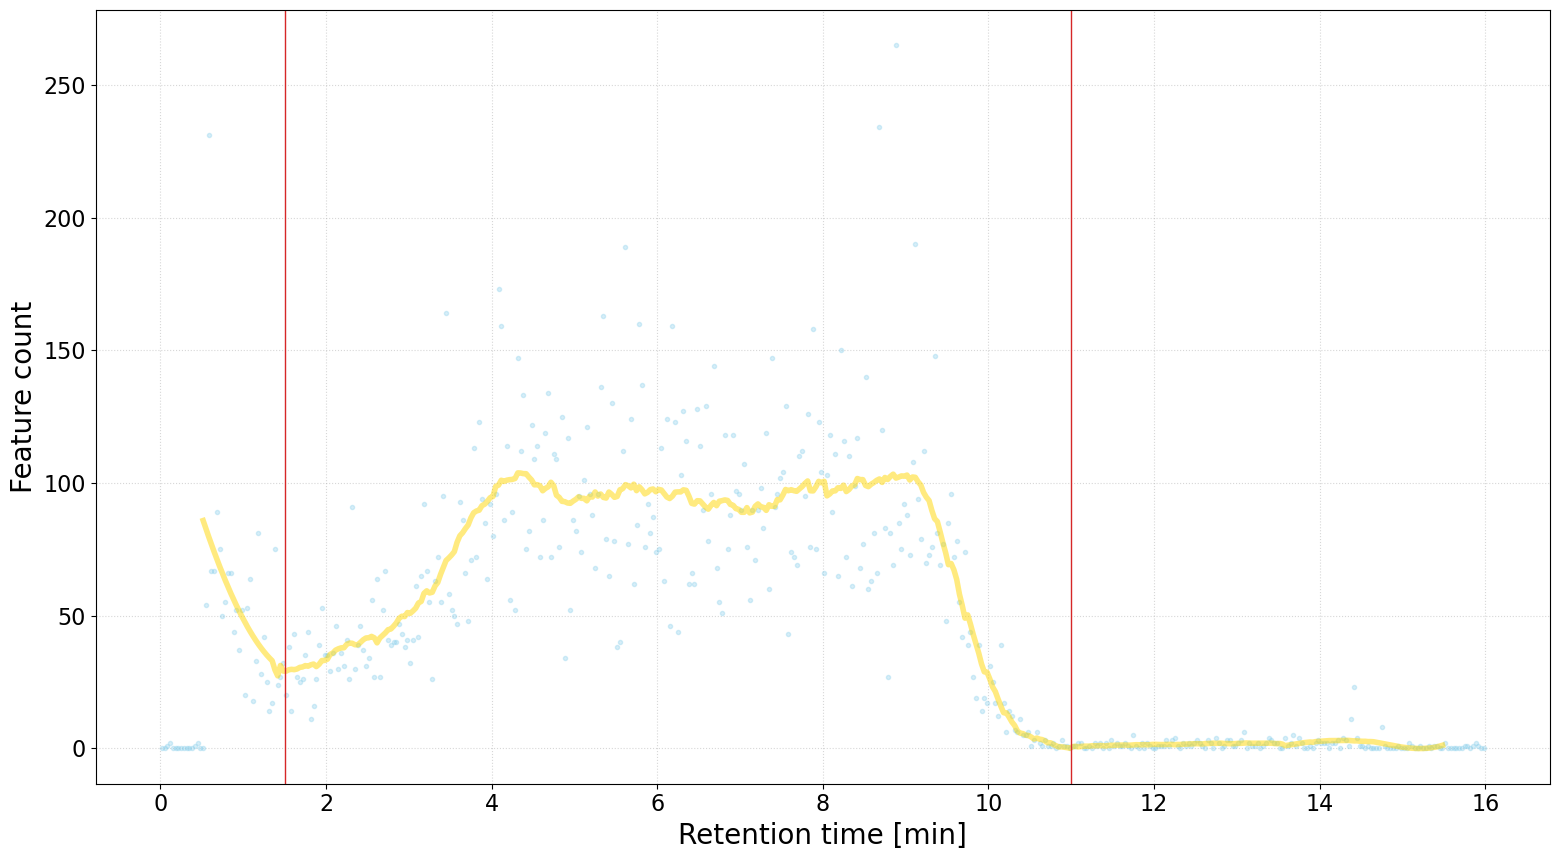

In [10]:
values = df['rt']/60

print(numpy.max(values))
print(numpy.min(values))

found_min = 0 
found_max = 16
number_of_bins = found_max*30

hist, bin_edges = numpy.histogram(values, bins=number_of_bins, range=(found_min, found_max))
half_bin = (bin_edges[1] - bin_edges[0])/2
x = bin_edges + half_bin
x = x[:-1]

matplotlib.pyplot.plot(x, hist, '.', alpha=1/3, color='skyblue')

margin = 15
plotting_x = x[margin:number_of_bins-margin]
plotting_hist = hist[margin:number_of_bins-margin]

yhat = scipy.signal.savgol_filter(plotting_hist, 51, 3)
matplotlib.pyplot.plot(plotting_x, yhat, '-', lw=4, alpha=1/2, color='gold')
      
matplotlib.pyplot.xlabel('Retention time [min]')
matplotlib.pyplot.ylabel('Feature count')
matplotlib.pyplot.grid(ls=':', alpha=0.5)

matplotlib.pyplot.axvline(x=1.5, lw=1, color='tab:red')
matplotlib.pyplot.axvline(x=11, lw=1, color='tab:red')


matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [11]:
print(df.shape)
df = df[df['rt'] >= 1.5*60]
print(df.shape)
df = df[df['rt'] <= 11*60]
print(df.shape)

(22507, 223)
(20943, 223)
(20715, 223)


## visualize internal standards

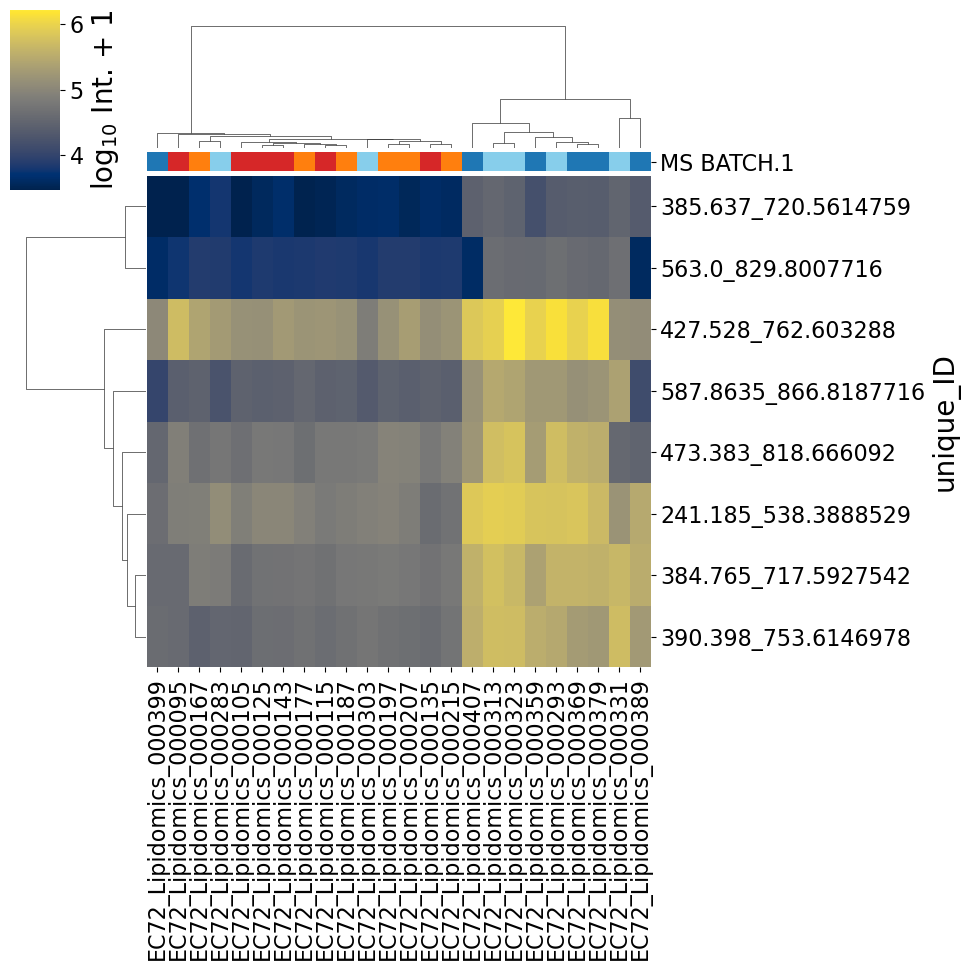

In [12]:
palette = dict(zip(['B1_1', 'B1_2', 'B2_1', 'B2_2'], ['skyblue','tab:blue','tab:red', 'tab:orange']))
my_col_colors = metadata.loc[log10_pools_intensities.columns, 'MS BATCH.1'].map(palette)

pdf = log10_pools_intensities.loc[IS_IDs, :]

seaborn.clustermap(pdf, row_cluster=True, col_cluster=True, cmap='cividis',
                   method='ward', metric='euclidean', 
                   col_colors=my_col_colors,
                   cbar_kws={'label': 'log$_{10}$ Int. + 1'} 
                   )
matplotlib.pyplot.show()

In [13]:
# m = log10iss.mean(axis=1)
# s = log10iss.std(axis=1)
# cv = s/m

# seaborn.violinplot(cv, color='skyblue')
# seaborn.swarmplot(cv, color='gold', size=20)

# matplotlib.pyplot.ylim(0, 0.5)
# matplotlib.pyplot.grid(ls=':', alpha=0.5)
# matplotlib.pyplot.xlabel('ISs')
# matplotlib.pyplot.ylabel('log10 CV')
# matplotlib.pyplot.show()

In [14]:
# CV in log scaled data https://en.wikipedia.org/wiki/Coefficient_of_variation

#cv = 

## visualize samples

In [15]:
log10_pools_and_samples_intensities.shape


(22507, 156)

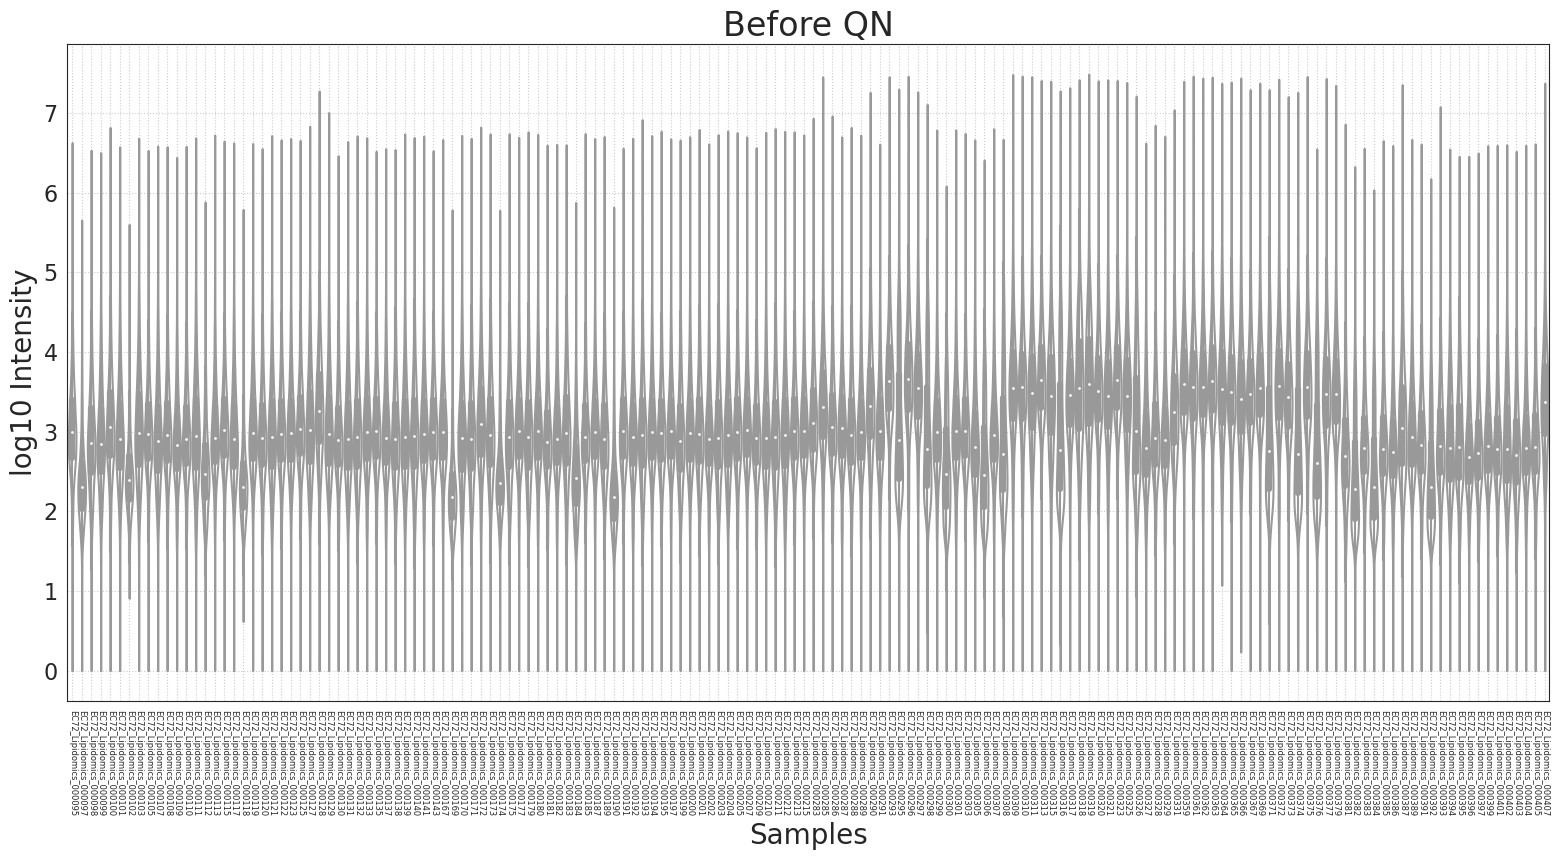

In [16]:
seaborn.set_style("white")
g = seaborn.violinplot(data=log10_pools_and_samples_intensities, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='Before QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

# quantile normalization

In [17]:
###
### quantile normalization |  taken from https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/
###

# step 1/3: sorting sample values
df_sorted = pandas.DataFrame(numpy.sort(log10_pools_and_samples_intensities.values, axis=0), 
                             index=log10_pools_and_samples_intensities.index, 
                             columns=log10_pools_and_samples_intensities.columns)
# step 2/3: averaging rank values across samples
df_mean = df_sorted.mean(axis=1)
df_mean.index = numpy.arange(1, len(df_mean) + 1)
# step 3/3: re-ordering samples
df_qn = log10_pools_and_samples_intensities.rank(method="min").stack().astype(int).map(df_mean).unstack()

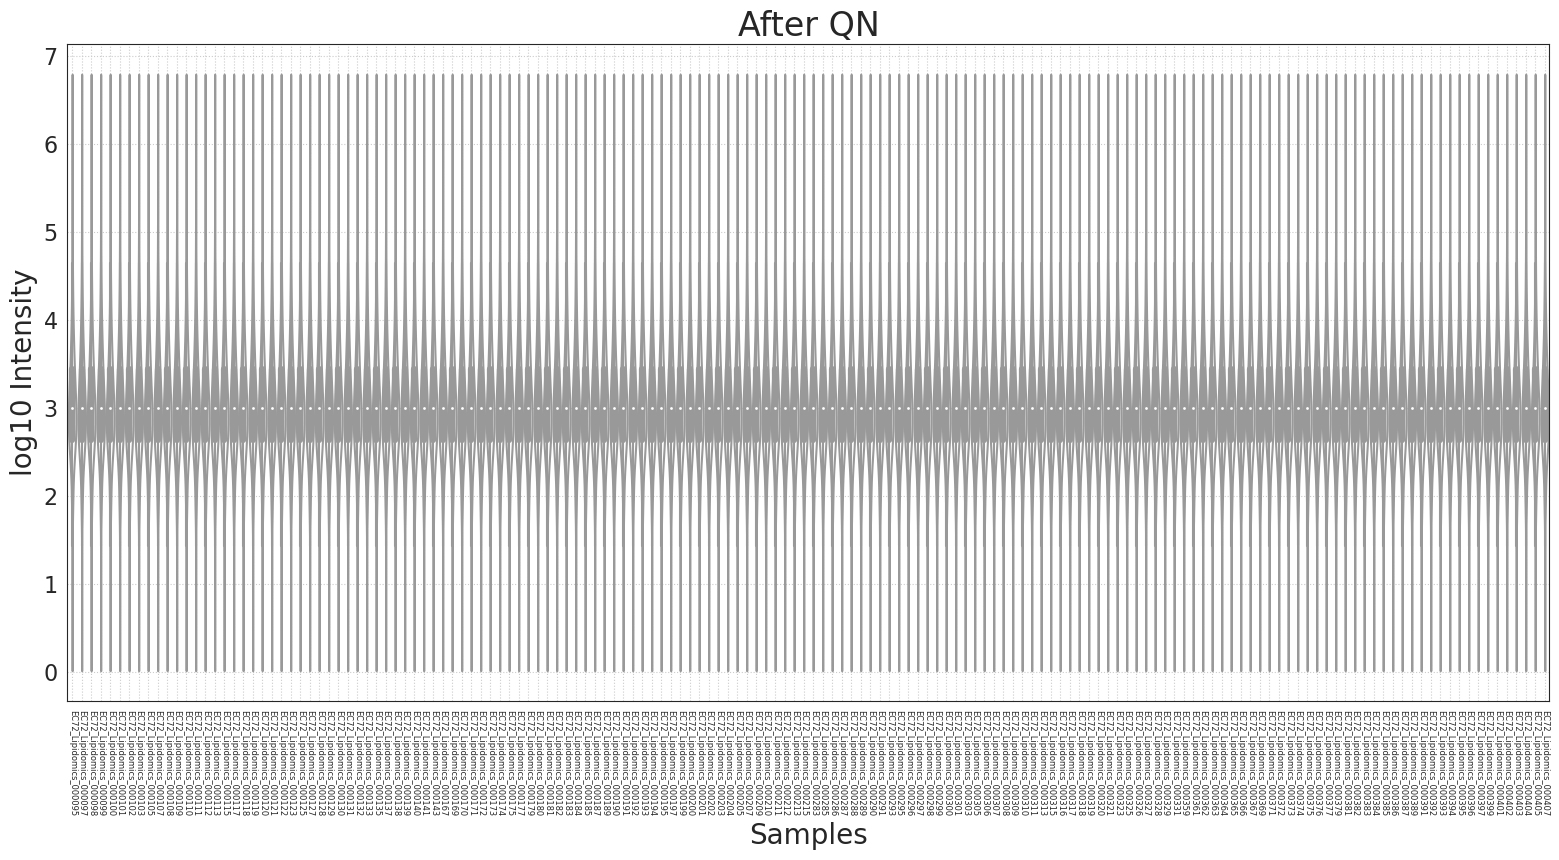

In [18]:
g = seaborn.violinplot(data=df_qn, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='After QN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [19]:
mqndf = qnorm.quantile_normalize(log10_pools_and_samples_intensities, axis=1)

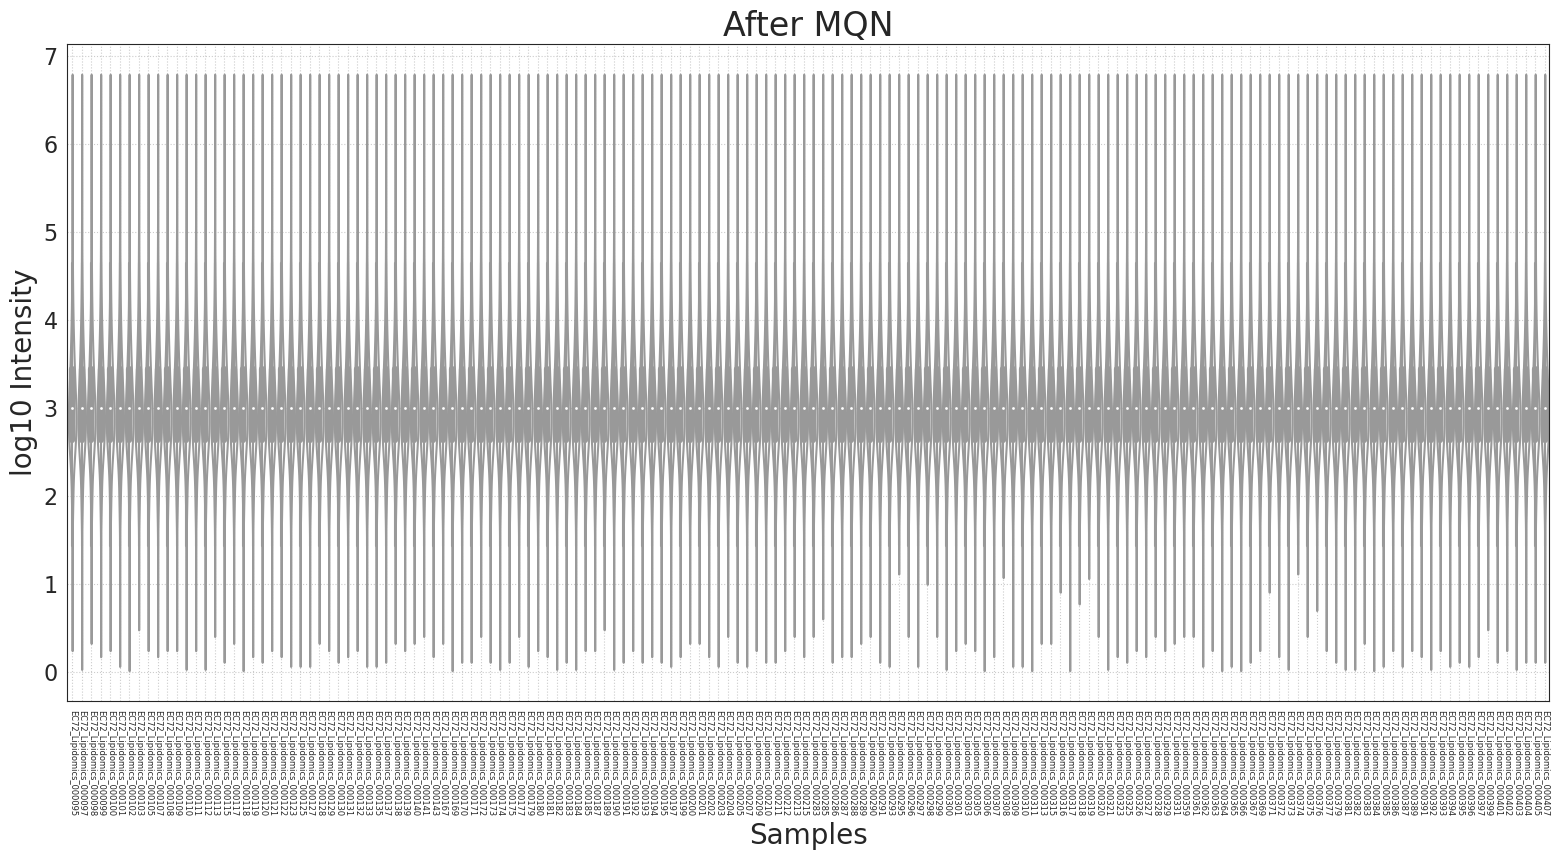

In [20]:
g = seaborn.violinplot(data=mqndf, cut=0, bw=.15, scale="count", color='white')
g.set(ylabel='log10 Intensity', xlabel='Samples', title='After MQN')
g.set_xticklabels(g.get_xticklabels(), rotation=-90, fontsize=6)

matplotlib.pyplot.grid(ls=':')
matplotlib.pyplot.tight_layout()
matplotlib.pyplot.show()

In [21]:
### vvisualize IS in pools after normalization

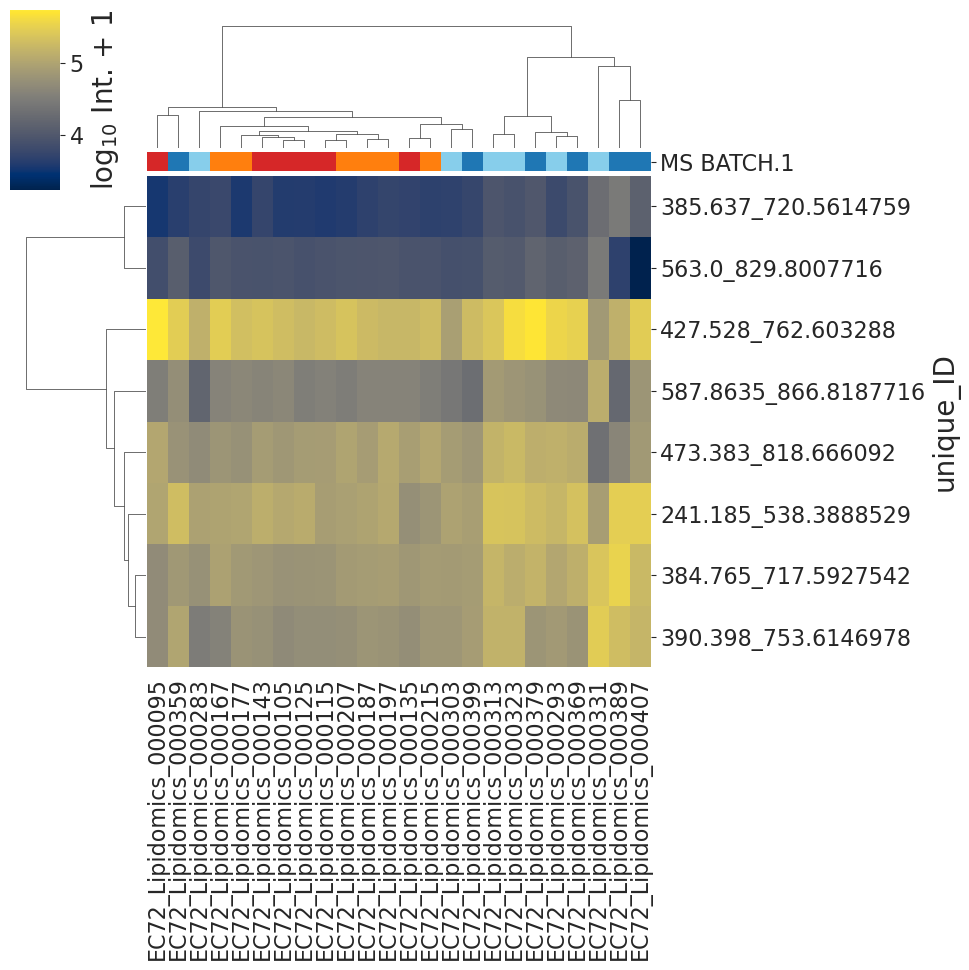

In [22]:
pdf = df_qn.loc[IS_IDs, pools_IDs]

palette = dict(zip(['B1_1', 'B1_2', 'B2_1', 'B2_2'], ['skyblue','tab:blue','tab:red', 'tab:orange']))
my_col_colors = metadata.loc[pdf.columns, 'MS BATCH.1'].map(palette)

seaborn.clustermap(pdf, row_cluster=True, col_cluster=True, cmap='cividis',
                   method='ward', metric='euclidean', 
                   col_colors=my_col_colors,
                   cbar_kws={'label': 'log$_{10}$ Int. + 1'} 
                   )
matplotlib.pyplot.show()

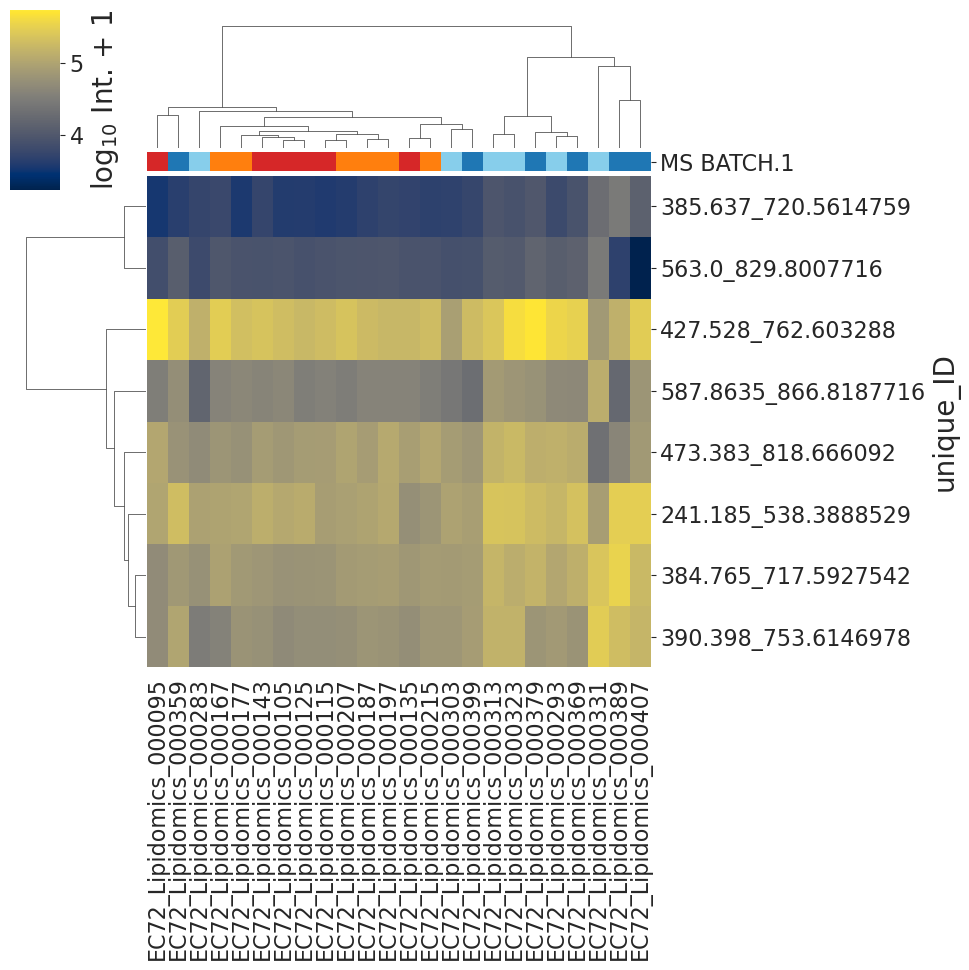

In [23]:
pdf = mqndf.loc[IS_IDs, pools_IDs]

palette = dict(zip(['B1_1', 'B1_2', 'B2_1', 'B2_2'], ['skyblue','tab:blue','tab:red', 'tab:orange']))
my_col_colors = metadata.loc[pdf.columns, 'MS BATCH.1'].map(palette)

seaborn.clustermap(pdf, row_cluster=True, col_cluster=True, cmap='cividis',
                   method='ward', metric='euclidean', 
                   col_colors=my_col_colors,
                   cbar_kws={'label': 'log$_{10}$ Int. + 1'} 
                   )
matplotlib.pyplot.show()